# EDA

In [1]:
!nvidia-smi

Tue Feb 21 22:45:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:09:00.0  On |                  N/A |
| 54%   30C    P8    N/A /  75W |    526MiB /  4096MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Environment

In [2]:
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

## Import Library

In [23]:
import sys
import os

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    ToTensord
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.teeth_dataset import get_data_dicts
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info

## Prepare data dicts

In [4]:
data_dir = r'D:\home\school\ntut\dataset\teeth'

In [5]:
data_dicts = get_data_dicts(data_dir)

## Show data info

pid: D:\home\school\ntut\dataset\teeth\image\1001142392_20180511
file_pth: D:\home\school\ntut\dataset\teeth\image\1001142392_20180511.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26.]


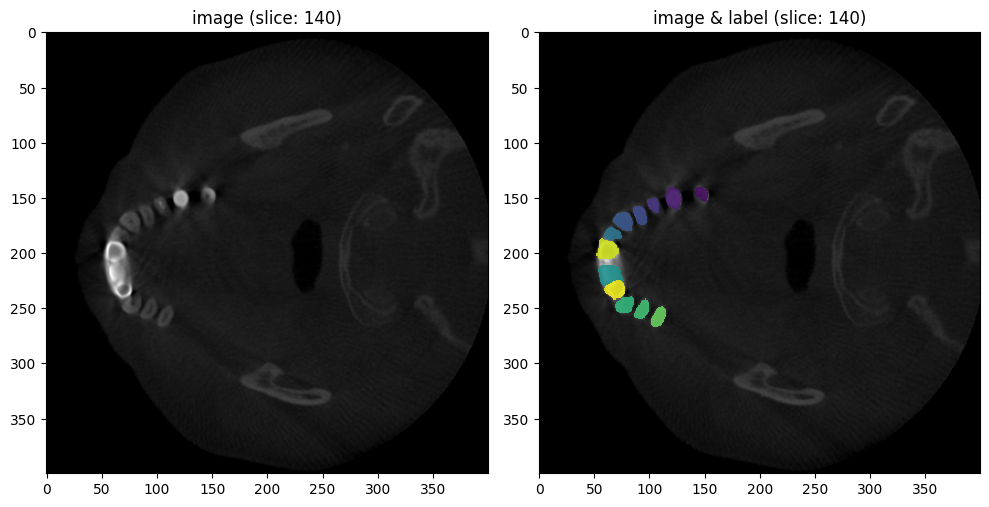

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: D:\home\school\ntut\dataset\teeth\image\1001152328_20150714
file_pth: D:\home\school\ntut\dataset\teeth\image\1001152328_20150714.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22.]


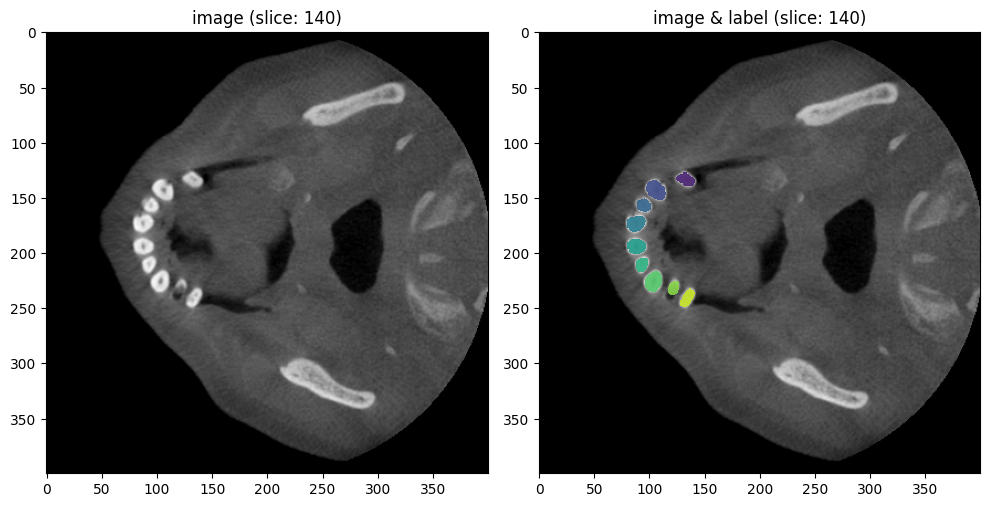

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: D:\home\school\ntut\dataset\teeth\image\1001162439_20140520
file_pth: D:\home\school\ntut\dataset\teeth\image\1001162439_20140520.nii.gz
img shape: [400, 400, 328]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 328]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]


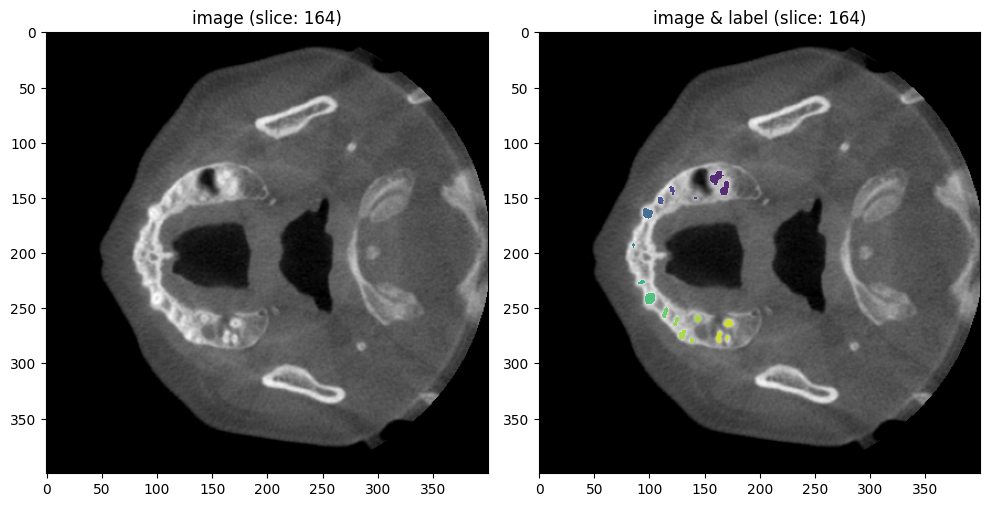

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: D:\home\school\ntut\dataset\teeth\image\1001162439_20150708
file_pth: D:\home\school\ntut\dataset\teeth\image\1001162439_20150708.nii.gz
img shape: [400, 400, 272]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 272]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.]


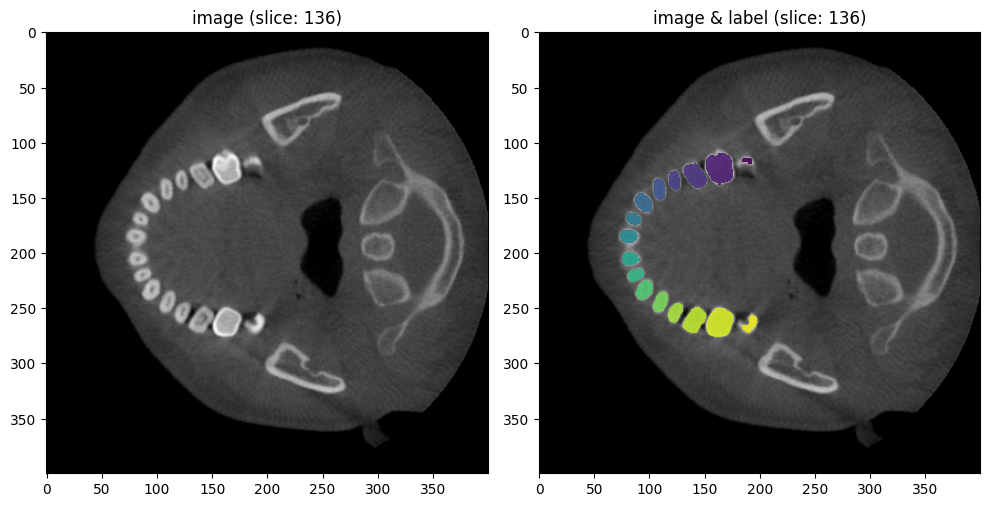

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: D:\home\school\ntut\dataset\teeth\image\1001172283_20190622
file_pth: D:\home\school\ntut\dataset\teeth\image\1001172283_20190622.nii.gz
img shape: [400, 400, 280]
img spacing: [0.4, 0.4, 0.40000057]
lbl shape: [400, 400, 280]
lbl spacing: [0.4, 0.4, 0.40000057]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26.]


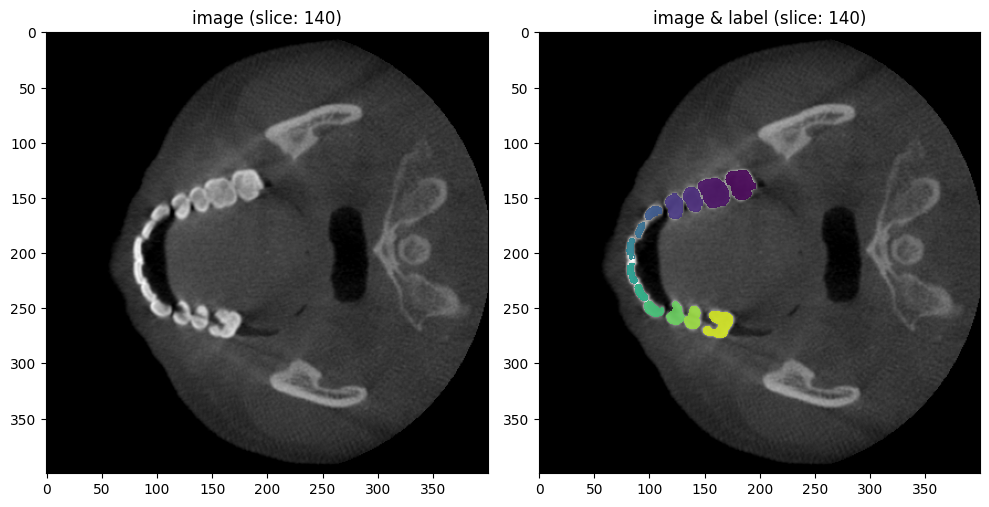

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: D:\home\school\ntut\dataset\teeth\image\1001218388_20161024
file_pth: D:\home\school\ntut\dataset\teeth\image\1001218388_20161024.nii.gz
img shape: [400, 400, 264]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 264]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25.]


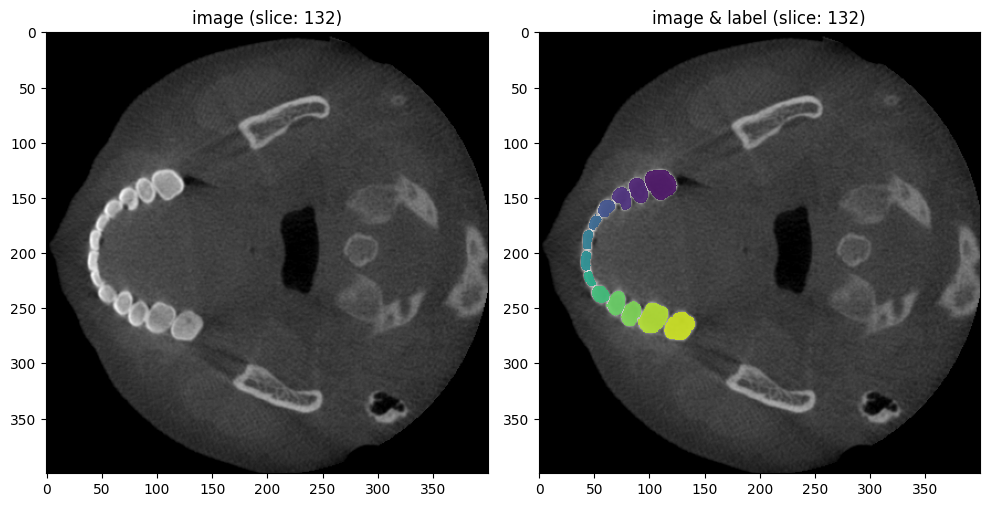

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: D:\home\school\ntut\dataset\teeth\image\1001223657_20180112
file_pth: D:\home\school\ntut\dataset\teeth\image\1001223657_20180112.nii.gz
img shape: [400, 400, 256]
img spacing: [0.4, 0.4, 0.39999998]
lbl shape: [400, 400, 256]
lbl spacing: [0.4, 0.4, 0.39999998]
lbl ids: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25.]


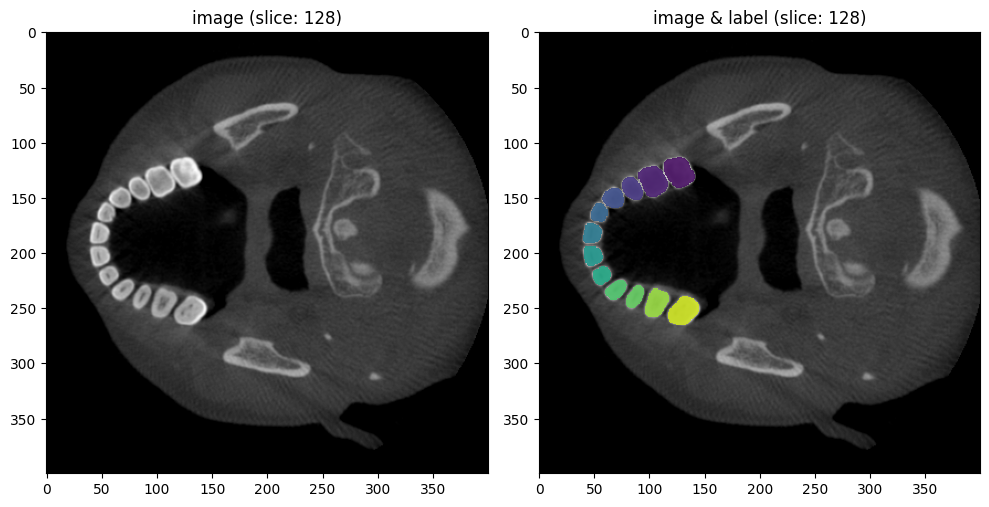

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: D:\home\school\ntut\dataset\teeth\image\1001247962_20180115
file_pth: D:\home\school\ntut\dataset\teeth\image\1001247962_20180115.nii.gz
img shape: [400, 400, 328]
img spacing: [0.4, 0.4, 0.39999962]
lbl shape: [400, 400, 328]
lbl spacing: [0.4, 0.4, 0.39999962]
lbl ids: [ 0.  4.  7.  8.  9. 10. 11. 14. 15. 16. 17. 19. 20. 22. 23. 25. 26. 28.
 29. 30. 32. 33. 35. 36.]


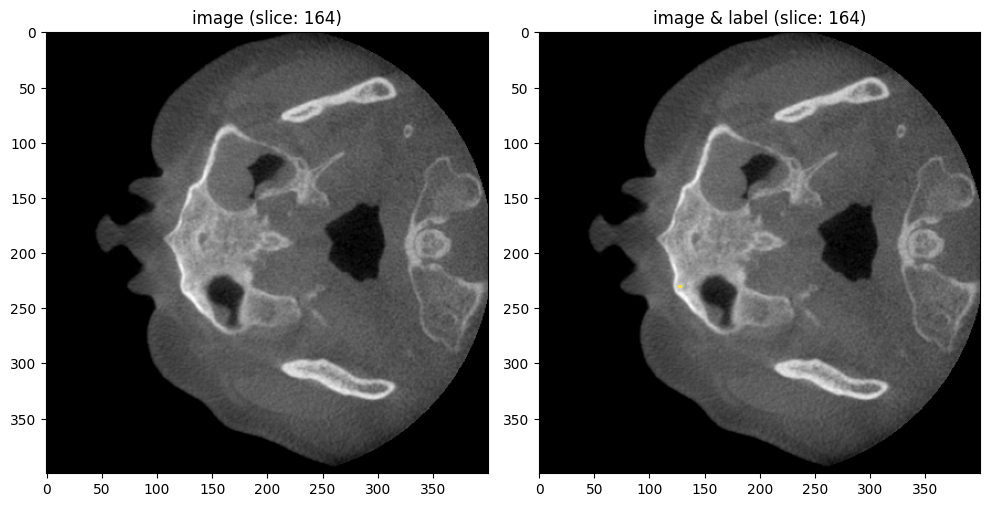

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [6]:
data_info_df = get_data_info(data_dicts)

In [7]:
data_info_df

,pid,img_shape,img_space,lbl_shape,lbl_space,lbl_ids
0,D:\home\school\ntut\dataset\teeth\image\100114...,"[400, 400, 280]","[0.4, 0.4, 0.40000057]","[400, 400, 280]","[0.4, 0.4, 0.40000057]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,D:\home\school\ntut\dataset\teeth\image\100115...,"[400, 400, 280]","[0.4, 0.4, 0.40000057]","[400, 400, 280]","[0.4, 0.4, 0.40000057]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,D:\home\school\ntut\dataset\teeth\image\100116...,"[400, 400, 328]","[0.4, 0.4, 0.39999962]","[400, 400, 328]","[0.4, 0.4, 0.39999962]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,D:\home\school\ntut\dataset\teeth\image\100116...,"[400, 400, 272]","[0.4, 0.4, 0.39999962]","[400, 400, 272]","[0.4, 0.4, 0.39999962]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,D:\home\school\ntut\dataset\teeth\image\100117...,"[400, 400, 280]","[0.4, 0.4, 0.40000057]","[400, 400, 280]","[0.4, 0.4, 0.40000057]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
5,D:\home\school\ntut\dataset\teeth\image\100121...,"[400, 400, 264]","[0.4, 0.4, 0.39999962]","[400, 400, 264]","[0.4, 0.4, 0.39999962]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
6,D:\home\school\ntut\dataset\teeth\image\100122...,"[400, 400, 256]","[0.4, 0.4, 0.39999998]","[400, 400, 256]","[0.4, 0.4, 0.39999998]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
7,D:\home\school\ntut\dataset\teeth\image\100124...,"[400, 400, 328]","[0.4, 0.4, 0.39999962]","[400, 400, 328]","[0.4, 0.4, 0.39999962]","[0.0, 4.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 15..."


In [8]:
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
data_shape_df.mean()

w    400.0
h    400.0
s    286.0
dtype: float64

In [9]:
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])
data_space_df.mean()

x    0.4
y    0.4
z    0.4
dtype: float32

## Statcics

In [10]:
base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=data_dicts,
    transform=base_tf
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
Loading dataset: 100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


In [11]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
min_percentile = 0.5
max_percentile = 99.5
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile,max_percentile)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [12]:
print('data target space:')
data_target_space

data target space:


(0.4000000059604645, 0.4000000059604645, 0.39999979734420776)

In [13]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', f'min_percentile ({min_percentile}%)', f'max_percentile ({min_percentile}%)']
)
data_intensities_statcics

data intensities statcics:


,min,med,max,mean,std,min_percentile (0.5%),max_percentile (0.5%)
0,-1000.0,1357.0,16127.0,1419.473999,549.857605,427.0,4702.335


## Transform

In [27]:
space = data_target_space
a_min = s.data_min_percentile
a_max = s.data_max_percentile
transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          ScaleIntensityRangePercentilesd(
              keys=["image"], lower=1, upper=99, b_min=0.0, b_max=1.0, clip=True
          ),
          # ScaleIntensityRanged(
          #     keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          # ),
          ToTensord(keys=["image", "label"])
      ]
  )

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [30]:
data = None
del data
data = transform(data_dicts[1])

label cls: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22.])


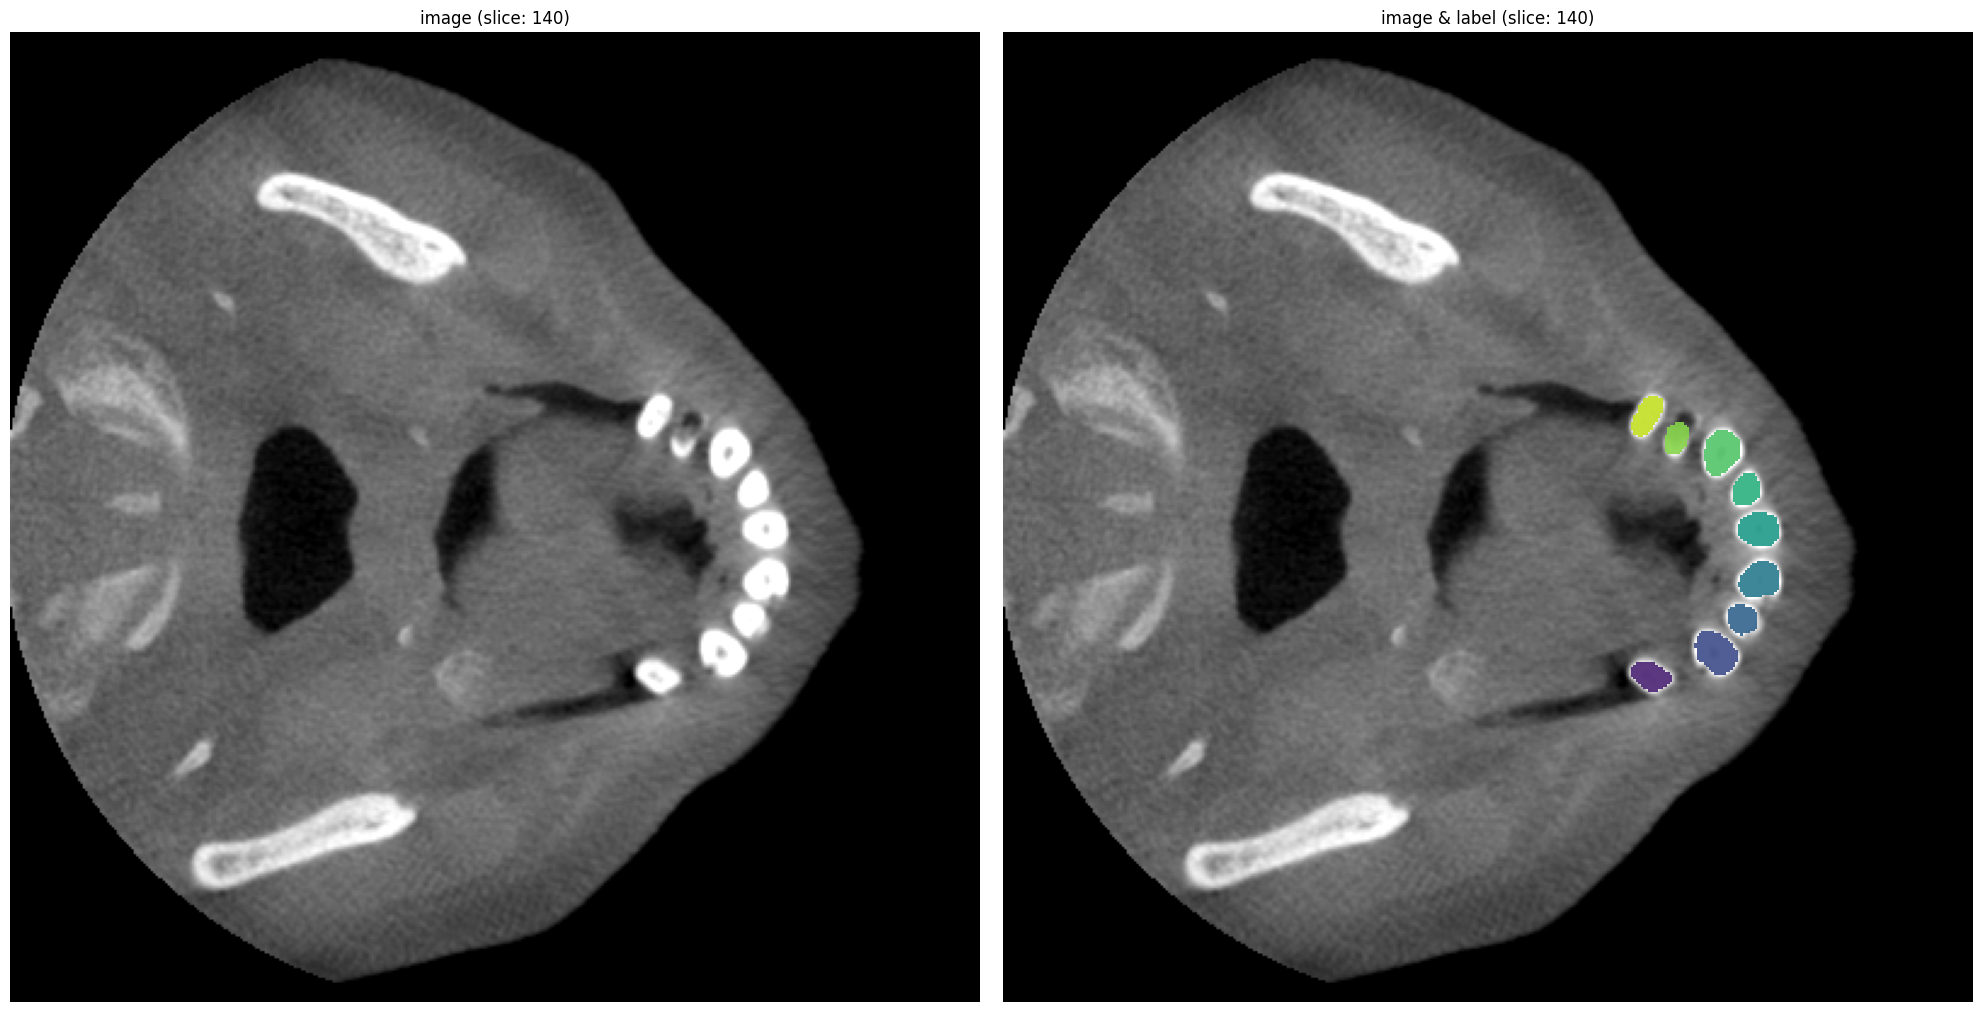

In [31]:
slice_num = data['image'].shape[-1] // 2
lbl_cls = data['label'].flatten().unique()
num_classes = len(data['label'].flatten().unique())
img = data['image'][0, :, :, slice_num]
lbl = data['label'][0, :, :, slice_num]
print('label cls:', lbl_cls)
show_img_lbl(
    img,
    lbl,
    slice_num,
    num_classes
)